In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm as tqdm
import sys

sys.path.append('..')
import interpolator
import pyvo

import sys, os
wdmodels_dir = os.environ['WDMODELS_DIR']
sys.path.append(wdmodels_dir)
import WD_models

plt.style.use('stefan.mplstyle')

In [10]:
"""compute the radial velocity from radius and effective temperature
"""
mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
font_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_function = WD_models.interp_xy_z_func(x = 10**font_model['logteff'], y = rsun,\
                                            z = font_model['logg'], interp_type = 'linear')
logg_function(80000, 7.11)

array(nan)

In [19]:
tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
QUERY = f"""select top 1000 *
        from \"J/MNRAS/508/3877/maincat\"
        where TeffH is not NULL and MassH is not NULL and meanAV is not NULL and RPlx > 3"""
ngfdata = tap_service.search(QUERY).to_table().to_pandas()

In [20]:
def fit_row(row : pd.Series, interp : interpolator.WarwickPhotometry):
    plx, zp, av = row.Plx, row.ZPcor, row.meanAV
    dist = 1000 / (plx + zp)
    mags = row[['GmagCorr', 'BPmag', 'RPmag']].values
    e_mags = row[['e_GmagCorr', 'e_BPmag', 'e_RPmag']].values
    fluxes, e_fluxes = interpolator.fit.mag_to_flux(mags, e_mags, interp.bands)
    res = interpolator.fit.coarse_fit(flux = fluxes, e_flux = e_fluxes, interp = interp, distance = dist, av = av,
                logg_function = logg_function, p0 = [10000, 0.012, 0.6], coarse_kws = {'method':'leastsq', 'nan_policy':'propagate'})
    return res

interp = interpolator.WarwickPhotometry(model='1d_da_nlte', bands=['Gaia_G', 'Gaia_BP', 'Gaia_RP'], speckws={'wavl_range' : (1000,14000)})
values = np.zeros((len(ngfdata), 5))
for i, row in tqdm.tqdm(ngfdata.iterrows(), total=len(ngfdata)):
    res = fit_row(row, interp)
    teff, radius, distance = res.params['teff'].value, res.params['radius'].value, res.params['distance'].value
    av = res.params['av'].value#, res.params['mass'].value
    values[i,0] = row.GaiaEDR3
    values[i,1] = teff
    values[i,2] = radius
    values[i,3] = distance
    values[i,4] = av
    #values[i,5] = mass
leastsq = pd.DataFrame(values, columns=['GaiaEDR3', 'teff', 'radius', 'distance', 'av'])

100%|██████████| 1000/1000 [00:54<00:00, 18.39it/s]


In [21]:
def interpolate_massteff(massarray : np.array, teffarray : np.array, Hlayer : str = 'thick') -> np.array:
    """compute the radial velocity from mass and effective temperature
    """
    assert Hlayer in ['thick', 'thin'], 'Hlayer must be either "thick" or "thin"'
    mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
    font_model = WD_models.load_model('f', 'f', 'f', 'H') if Hlayer == 'thick' else WD_models.load_model('f', 'ft', 'f', 'H')
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    mass_teff_to_radius = WD_models.interp_xy_z_func(x = font_model['mass_array'], y = 10**font_model['logteff'],\
                                                z = rsun, interp_type = 'linear')
    radius = mass_teff_to_radius(massarray, teffarray)
    return radius

ngfdata['RadiusH'] = interpolate_massteff(ngfdata.MassH.values, ngfdata.TeffH.values, Hlayer = 'thick')
leastsq['logg'] = logg_function(leastsq.teff, leastsq.radius)
leastsq['mass'] = (1e-2*10**leastsq.logg * ((leastsq.radius*radius_sun)**2 / newton_G))/mass_sun
leastsq = leastsq.query("mass > 0.46")

In [22]:
comparison = pd.merge(leastsq, ngfdata, on='GaiaEDR3')
comparison['teff_pct_err'] = (comparison.teff - comparison.TeffH) / comparison.teff * 100
comparison['radius_pct_err'] = (comparison.radius - comparison.RadiusH) / comparison.radius * 100
comparison['av_pct_err'] = (comparison.av - comparison.meanAV) / comparison.av * 100
comparison['distance_pct_err'] = (comparison.distance - comparison.rgeo) / comparison.distance * 100
comparison['logg_pct_err'] = (comparison.logg - comparison.loggH) / comparison.logg * 100
#comparison[['GaiaEDR3', 'teff', 'TeffH', 'radius', 'RadiusH', 'logg', 'loggH']]

In [ ]:
comparison

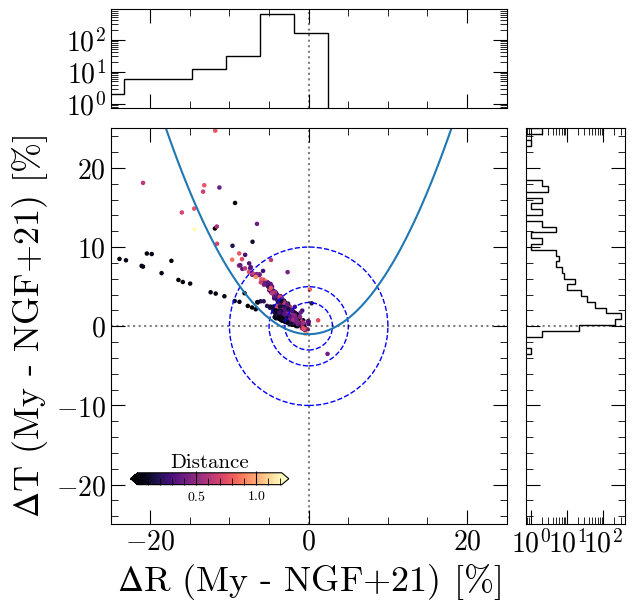

In [51]:
import matplotlib.patches as patches

def scatter_hist(x, y, z, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    scatter = ax.scatter(x, y, c = z, s = 5)
    ax.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    # now determine nice limits by hand:
    binwidth = 0.25
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth) + 1) * binwidth
    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color = 'k', histtype = 'step')
    ax_histx.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histy.hist(y, bins=100, orientation='horizontal', color = 'k', histtype = 'step')
    ax_histy.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histx.set_yscale('log')
    ax_histy.set_xscale('log')
    return scatter

#fig, ax = plt.subplots(ncols=1, figsize=(8,6), sharey=False)
fig = plt.figure(layout='constrained', figsize=(8,6))
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

temp_compare = comparison.copy()
scatter_mass = scatter_hist(temp_compare.radius_pct_err, temp_compare.teff_pct_err, z = temp_compare.av, ax = ax, 
                            ax_histx = ax_histx, ax_histy = ax_histy)
confidence_ellipses = [3, 5, 10]
for val in confidence_ellipses:
    circle = patches.Circle((0, 0), val, edgecolor='blue', facecolor='none', ls = '--', linewidth=1, label='')
    ax.add_patch(circle)
ax.set_xlabel(r'$\Delta R$ (My - NGF+21) [%]')
ax.set_ylabel(r'$\Delta T$ (My - NGF+21) [%]')
ax.set_xlim(-25,25)
ax.set_ylim(-25,25)

xvals = np.linspace(-20,20,100)
ax.plot(xvals, 0.08*xvals**2-1)

cbaxes = ax.inset_axes([.05, .10, .4, .03]) 
cb = fig.colorbar(scatter_mass, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"Distance", size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

#fig.tight_layout()

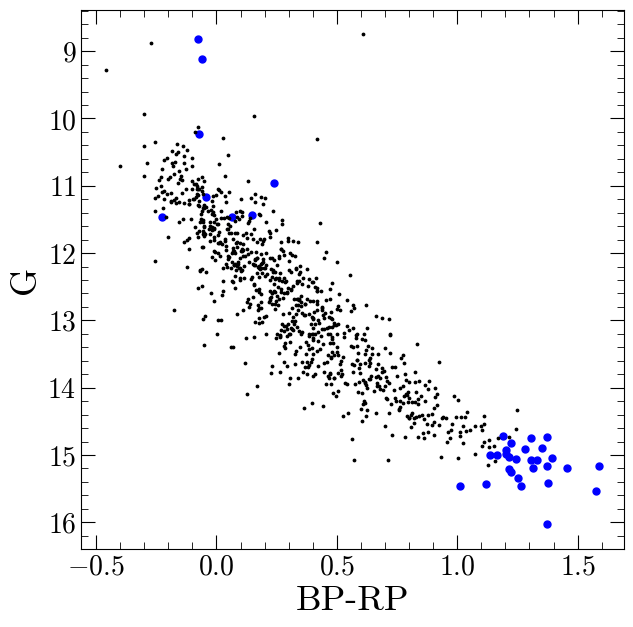

In [62]:
aaa = comparison.query("teff_pct_err < 0.08*radius_pct_err**2-1")
bbb = comparison.query("teff_pct_err > 0.08*radius_pct_err**2-1")

plt.scatter(aaa["BP-RP"], aaa.Gmag - 5*np.log10(aaa.rgeo)+5, c = 'blue')
plt.scatter(bbb["BP-RP"], bbb.Gmag - 5*np.log10(bbb.rgeo)+5, c='k', s=3)
plt.xlabel("BP-RP")
plt.ylabel("G")
plt.gca().invert_yaxis()